<a href="https://colab.research.google.com/github/cmplx-xyttmt/mlops/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLOps workflow

We'll be using GCP and Vertex AI.

## Setting up GCP

In [16]:
from IPython.display import clear_output




In [18]:
# Login to gcloud
!gcloud auth login
clear_output()

In [4]:
# Set the working project
!gcloud config set project sb-gcp-project-01

Updated property [core/project].


In [5]:
# Confirm that the project is set
!gcloud config list project

[core]
project = sb-gcp-project-01

Your active configuration is: [default]


In [ ]:
# (Optional) Enable required services.
!gcloud services enable \
  compute.googleapis.com \
  iam.googleapis.com \
  iamcredentials.googleapis.com \
  monitoring.googleapis.com \
  logging.googleapis.com \
  notebooks.googleapis.com \
  aiplatform.googleapis.com \
  bigquery.googleapis.com \
  artifactregistry.googleapis.com \
  cloudbuild.googleapis.com \
  container.googleapis.com

In [9]:
# create a service account for custom training
import os
os.environ['SERVICE_ACCOUNT_ID'] = 'vertex-custom-training-sunbird'
!echo $SERVICE_ACCOUNT_ID
!gcloud iam service-accounts create $SERVICE_ACCOUNT_ID --description="A custom service account for Vertex custom training." --display-name="Vertex AI Custom Training"

vertex-custom-training-sunbird
Created service account [vertex-custom-training-sunbird].


In [19]:
# Grant service account access to Cloud Storage
PROJECT_ID=!(gcloud config get-value core/project)
PROJECT_ID = PROJECT_ID[0]
os.environ['PROJECT_ID'] = PROJECT_ID

!gcloud projects add-iam-policy-binding $PROJECT_ID --member=serviceAccount:$SERVICE_ACCOUNT_ID@$PROJECT_ID.iam.gserviceaccount.com --role="roles/storage.admin"
clear_output()

In [20]:
!gcloud projects add-iam-policy-binding $PROJECT_ID --member=serviceAccount:$SERVICE_ACCOUNT_ID@$PROJECT_ID.iam.gserviceaccount.com --role="roles/aiplatform.user"
clear_output()

## Data processing and exploration

In [ ]:
# TODO: Add an example of reading data from a GCS bucket.

In [26]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:20<00:00, 1314526.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 116412.03it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:09<00:00, 472029.02it/s] 


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17455357.31it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



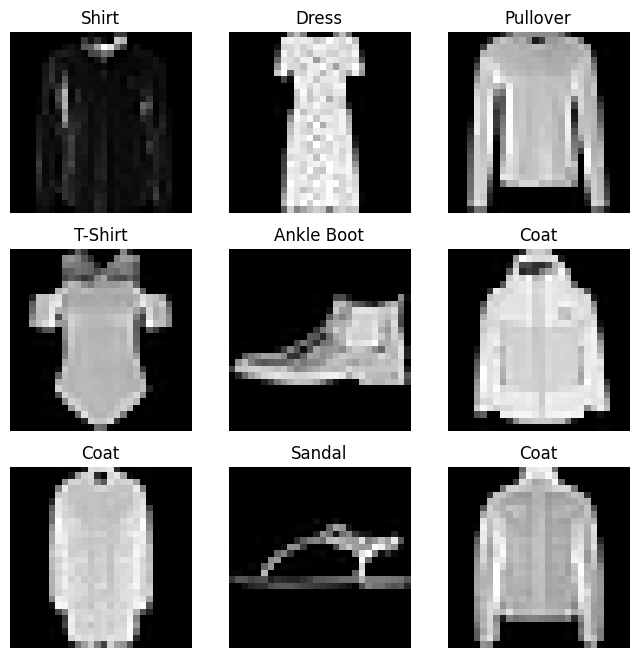

In [27]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


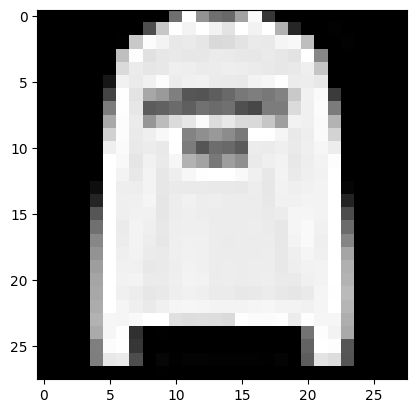

Label: 2


In [29]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Training a model


In [33]:
import os
from torch import nn
from torchvision import transforms

In [31]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cpu device


In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [35]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [36]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([0])


In [37]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0106,  0.0313, -0.0098,  ..., -0.0171,  0.0192,  0.0151],
        [ 0.0273, -0.0312, -0.0105,  ...,  0.0170,  0.0037, -0.0237]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0117,  0.0166], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[-0.0148,  0.0311, -0.0129,  ...,  0.0157,  0.0219,  0.0174],
        [-0.0398,  0.0211, -0.0178,  ..., -0.0435,  0.0125,  0.0382]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | 

In [38]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

In [39]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [42]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.302540  [   64/60000]
loss: 2.283413  [ 6464/60000]
loss: 2.269550  [12864/60000]
loss: 2.252679  [19264/60000]
loss: 2.245815  [25664/60000]
loss: 2.222944  [32064/60000]
loss: 2.201847  [38464/60000]
loss: 2.181737  [44864/60000]
loss: 2.172928  [51264/60000]
loss: 2.158331  [57664/60000]
Test Error: 
 Accuracy: 49.1%, Avg loss: 2.144788 

Epoch 2
-------------------------------
loss: 2.141716  [   64/60000]
loss: 2.091076  [ 6464/60000]
loss: 2.114393  [12864/60000]
loss: 2.079768  [19264/60000]
loss: 2.039138  [25664/60000]
loss: 1.995826  [32064/60000]
loss: 2.009272  [38464/60000]
loss: 1.955707  [44864/60000]
loss: 1.955427  [51264/60000]
loss: 1.906097  [57664/60000]
Test Error: 
 Accuracy: 59.9%, Avg loss: 1.863328 

Epoch 3
-------------------------------
loss: 1.839163  [   64/60000]
loss: 1.815001  [ 6464/60000]
loss: 1.806505  [12864/60000]
loss: 1.776136  [19264/60000]
loss: 1.620029  [25664/60000]
loss: 1.638207  [32064/600

In [ ]:
# To run this code asynchronously, containerize the training code with this format:
# |--/model-training
#     |--/trainer
#         |--__init__.py
#         |--model.py
#         |--task.py
#     |--Dockerfile
#     |--cloudbuild.yaml
#     |--requirements.txt

In [43]:
torch.save(model.state_dict(), 'model_weights.pth')

In [52]:
GCS_BUCKET = f"{PROJECT_ID}-mnist-bucket"
REGION = 'europe-west1'

In [50]:
!echo $REGION

europe-west1


In [51]:
# create a bucket to store the model
!gsutil mb -l $REGION gs://$GCS_BUCKET

Creating gs://sb-gcp-project-01-mnist-bucket/...


In [55]:
# upload model weights to bucket.
!gsutil cp model_weights.pth gs://$GCS_BUCKET/model_weights/model_weights.pth

Copying file://model_weights.pth [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/2.6 MiB.                                      
